# Fast Calderón Preconditioning for the Electric Field Integral Equation

## Comparison of preconditioners in a Bi-Parametric Framework

In this tutorial, we consider scattering by an incident plane wave traveling along x-axis and polarized along z-axis. We compare several preconditioners:
1. ${\bf (NONE)}_\nu$ is the unpreconditioned system;
2. ${\bf (DIAG)}_\nu$ stands for Jacobi or diagonal preconditioner; 
3. ${\bf (CALD)}_\varepsilon$ is the $\varepsilon$-Calderón;
4. ${\bf (CALD)}_{\mu,\nu}$ is the bi-parametric Calderón;
5. ${\bf (NF)}_{\mu,\nu}$ uses Near-Field (NF) preconditioning. It consists of (i) choosing a sparse NF pattern with integer distance parameter $\delta_{\bf NF}$ leading to $\mathbf{Z}_{\delta_{\bf NF}}^{near}$; and, (ii) Incomplete LU (ILU) factorization of $\mathbf{Z}_{\delta_{\bf NF}}^{near}$ with drop tolerance parameter $\mu_{\text{ILU}}$ leading to a preconditioner fully described by $\mu_{\bf{NF}}:=(\mu_{\text{ILU}},\delta_{\bf NF})$.

In geometry.py, we provide functions to obtain the geometries of the unit Fichera Cube --suitably graded for exterior domains-- and Destroyer. The original Destroyer geometry is inspired by a Puma-EM code (Copyright (C) 2016 Idesbald Van den Bosch).

As well, in login.py, we perform a few hacks of the original bempp code:
1. assemble_singular_part: add a distance parameter, that allows to consider more interactions, in order to assembly an adapted NF pattern;
2. assemble_diagonal: assembly the Jacobi preconditioner from the asssemble_singular_part function
2. gmres: allow to plug matrices or LinearOperators
3. InverseSparseDiscreteBoundaryOperator: add an ilu factorization with drop_tolerance parameter instead of lu


In [91]:
from __future__ import division
import bempp.api as bem
import numpy as np
from numpy.linalg import norm
import time
from login import get_h, gmres, translate, assemble_singular_part, \
     InverseSparseDiscreteBoundaryOperator, assemble_diagonal
from geometry import destroyer,reentrant_cube_exterior

bem.set_ipython_notebook_viewer()

### Definition of general parameters:

1. Wavenumber $\kappa$;
2. Tolerance parameters: 
    1. $\mu:=(\mu_{\mathcal{H}},\mathbf{q}_{\mathbf{C}})$;
    2. $\mu_{\bf{NF}}:=(\mu_{\text{ILU}},\delta_{\bf NF})$;
    3. $\nu :=(\nu_{\mathcal{H}},\mathbf{q}_{\mathbf{Z}})$;
    4. $\varepsilon:=(\varepsilon_{\mathcal{H}}, \mathbf{q}_{\mathbf{Z}^b})$;
3. Elements per wavelength $r$;
4. Mesh density $h$.

Quadrature parameters defined as: $\mathbf{q}_{\mathbf{Z}}:=[o_{near},o_{medium},o_{far},o_{sing}]$.

### Definition the problem:

1. Incident wave: $[e^{\imath \kappa x_1},0,0]$

In [61]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_mu= [1,1,1,2]
quad_nu= [4,3,2,6]
quad_dense= [10,10,10,12]
quad_eps= [4,3,2,6]

# NF parameters
distance = 5
mu_nf = 0.01

mu = 0.1
nu = 0.001
eps = 0.001

kappa = 1 # wavenumber
precision = 10 # precision r
h = 2.0 * np.pi / (precision * kappa)

bem.global_parameters.assembly.boundary_operator_assembly_type = "dense"


grid = reentrant_cube_exterior(h=1)

from bempp.api.space import project_operator # to perform projections from barycentric grid to adapted spaces

# Specify the incident field and its tangential component

def incident_field(x):
    return np.array([0.*x[0], 0.*x[1], -np.exp(1j * kappa * x[0])])
    #return np.array([np.exp(1j * kappa * x[2]), 0. * x[2], 0. * x[2]])

def tangential_trace(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n, axis=0)

################################################
# Parameters nu

parameters_nu = global_parameters()
if nu == -1:
	parameters_nu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_nu.assembly.boundary_operator_assembly_type='hmat'
parameters_nu.hmat.eps = nu
parameters_nu.quadrature.double_singular = quad_nu[3]
parameters_nu.quadrature.far.double_order = quad_nu[2]
parameters_nu.quadrature.medium.double_order = quad_nu[1]
parameters_nu.quadrature.near.double_order = quad_nu[0]

################################################
# Parameters mu

parameters_mu = global_parameters()
if mu == -1:
	parameters_mu.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_mu.assembly.boundary_operator_assembly_type='hmat'
parameters_mu.hmat.eps = mu
parameters_mu.quadrature.double_singular = quad_mu[3]
parameters_mu.quadrature.far.double_order = quad_mu[2]
parameters_mu.quadrature.medium.double_order = quad_mu[1]
parameters_mu.quadrature.near.double_order = quad_mu[0]
########################################################################
########################################################################



parameters_dense = global_parameters()
parameters_dense.assembly.boundary_operator_assembly_type='dense'
parameters_dense.hmat.eps = -1
parameters_dense.quadrature.double_singular = quad_dense[3]
parameters_dense.quadrature.far.double_order = quad_dense[2]
parameters_dense.quadrature.medium.double_order = quad_dense[1]
parameters_dense.quadrature.near.double_order = quad_dense[0]



parameters_eps = global_parameters()
if eps == -1:
	parameters_eps.assembly.boundary_operator_assembly_type='dense'
else:
	parameters_eps.assembly.boundary_operator_assembly_type='hmat'
parameters_eps.hmat.eps = eps
parameters_eps.quadrature.double_singular = quad_eps[3]
parameters_eps.quadrature.far.double_order = quad_eps[2]
parameters_eps.quadrature.medium.double_order = quad_eps[1]
parameters_eps.quadrature.near.double_order = quad_eps[0]


########################################################################
########################################################################

bc_space = bem.function_space(grid, "BC", 0)
rbc_space = bem.function_space(grid, "RBC", 0)
rwg_space = bem.function_space(grid, "RWG", 0)
snc_space = bem.function_space(grid, "SNC", 0)

rwg_bary_space = bem.function_space(grid.barycentric_grid(), "RWG", 0)
snc_bary_space = bem.function_space(grid.barycentric_grid(), "SNC", 0)

b_rwg_space = bem.function_space(grid, "B-RWG", 0)
b_snc_space = bem.function_space(grid, "B-SNC", 0)

N = int(rwg_space.global_dof_count)
print (N ,'NDOF')

# reference solution
efie_ref = bem.operators.boundary.maxwell.electric_field(rwg_space,rwg_space, snc_space, kappa, parameters=parameters_dense)

# define the operators for standard formulation
efie_none = bem.operators.boundary.maxwell.electric_field(rwg_space,rwg_space, snc_space, kappa, parameters = parameters_nu)
identity_none = bem.operators.boundary.sparse.identity(rwg_space,rwg_space, snc_space)
efie_bary = bem.operators.boundary.maxwell.electric_field(rwg_bary_space,rwg_bary_space, snc_bary_space, kappa, parameters = parameters_eps)

# define the operators for preconditioned formulation
efie_bc = bem.operators.boundary.maxwell.electric_field(bc_space,b_rwg_space, rbc_space, kappa, parameters=parameters_mu)
identity_hyp = bem.operators.boundary.sparse.identity(bc_space, b_rwg_space, b_snc_space)
identity_hyp_t = bem.operators.boundary.sparse.identity(b_rwg_space, b_rwg_space, rbc_space)
inv_identity_hyp = bem.assembly.InverseSparseDiscreteBoundaryOperator(identity_hyp.weak_form())
inv_identity_hyp_t = bem.assembly.InverseSparseDiscreteBoundaryOperator(identity_hyp_t.weak_form())

trace_fun_none = bem.GridFunction(rwg_space, fun=tangential_trace)
trace_fun_b_none = bem.GridFunction(b_rwg_space, fun=tangential_trace)
rhs_none = (identity_none * trace_fun_none).projections()


# Get the weak form for the standard formulation
#print 'assembly of efie_none'
t0 = time.time()
efie_none_wf = efie_none.weak_form()
ta_none = time.time()-t0


print ('assembly of Diag prec')
t0 = time.time()
efie_diag_wf = assemble_diagonal(efie_none)
tc_diag0 = time.time()-t0
t0 = time.time()
A_diag = bem.InverseSparseDiscreteBoundaryOperator(efie_diag_wf)
tc_diag1 = time.time()-t0

efie_diag_wf = A_diag * efie_none_wf
rhs_diag = A_diag * rhs_none

print('assembly of NF prec')
t0 = time.time()
efie_sing_wf = assemble_singular_part(efie_none, distance=distance)
tc_nf0 = time.time()-t0

t0 = time.time()
A_nf = InverseSparseDiscreteBoundaryOperator(efie_sing_wf, mu=mu_nf)
tc_nf1 = time.time()-t0

efie_prec_wf = A_nf * efie_none_wf
rhs_prec = A_nf * rhs_none

print('assembly of EFIE bary')
efie_rwg_bary = project_operator(efie_bary, b_rwg_space, b_rwg_space, b_snc_space)
efie_bc_bary = project_operator(efie_bary, bc_space,b_rwg_space, rbc_space)
t0 = time.time()
efie_rwg_bary_wf = efie_rwg_bary.weak_form()
efie_bc_bary_sf = efie_bc_bary.strong_form()
ta_eps = time.time()-t0


print('assembly of Cald prec bi')
t0 = time.time()
efie_bc_sf = efie_bc.strong_form()
tc_bi = time.time()-t0


rhs_hyp_eps =  efie_bc_bary_sf * inv_identity_hyp * rhs_none
efie_eps_sf = efie_bc_bary_sf * inv_identity_hyp * efie_rwg_bary_wf



efie_hyp_sf = efie_bc_sf * inv_identity_hyp * efie_none_wf
rhs_hyp_bi =  efie_bc_sf * inv_identity_hyp * rhs_none


tolerance = 1e-5
restart = 200
maxiter = 2000

print('solver of none')
t0 = time.time()
c_none,  info_none, res_none  = gmres(efie_none_wf, rhs_none, tol=tolerance, restart=restart, return_residuals=True, maxiter=maxiter)
ts_none = time.time()-t0
tma_none = len(res_none)/ts_none

print('solver of diag')
t0 = time.time()
c_diag,  info_diag, res_diag  = gmres(efie_diag_wf, rhs_diag, tol=tolerance, restart=restart, return_residuals=True, maxiter=maxiter)
ts_diag = time.time()-t0

print('solver of nf')
t0 = time.time()
c_nf,  info_nf, res_nf  = gmres(efie_prec_wf, rhs_prec, tol=tolerance, restart=restart, return_residuals=True, maxiter=maxiter)
ts_nf= time.time()-t0

print('solver of eps')
t0 = time.time()
c_eps,  info_eps, res_eps  = gmres(efie_eps_sf, rhs_hyp_eps, tol=tolerance, restart=restart, return_residuals=True, maxiter=maxiter)
ts_eps = time.time()-t0

print('solver of bi')
t0 = time.time()
c_bi,  info_bi, res_bi  = gmres(efie_hyp_sf, rhs_hyp_bi, tol=tolerance, restart=restart, return_residuals=True, maxiter=maxiter)
ts_bi = time.time()-t0


niter = 100
print('tmean of none')
t0 = time.time()
for i in range(niter):
	efie_none_wf.matvec(rhs_none)
tmean_none = (time.time()-t0)/niter

print('tmean of diag')
t0 = time.time()
for i in range(niter):
	efie_diag_wf.matvec(rhs_none)
tmean_diag = (time.time()-t0)/niter

print('tmean of nf')
t0 = time.time()
for i in range(niter):
	efie_prec_wf.matvec(rhs_none)
tmean_nf = (time.time()-t0)/niter

print('tmean of eps')
t0 = time.time()
for i in range(niter):
	efie_bempp_sf.matvec(rhs_none)
tmean_eps = (time.time()-t0)/niter

print('tmean of bi')
t0 = time.time()
for i in range(niter):
	efie_hyp_sf.matvec(rhs_none)
tmean_bi = (time.time()-t0)/niter

print(tmean_bi, 'tmean_bi')
c_rate_mu = bem.hmatrix_interface.compression_rate(efie_bc._operator._operator.weak_form())
c_rate_nu = bem.hmatrix_interface.compression_rate(efie_none_wf)
print(c_rate_mu, 'Compression rate mu')
print(c_rate_nu, 'Compression rate nu')
print('--------------------')


mem_mu = bem.hmatrix_interface.mem_size(efie_bc._operator._operator.weak_form())
mem_nu = bem.hmatrix_interface.mem_size(efie_none_wf)
mem_eps = bem.hmatrix_interface.mem_size(efie_rwg_bary._operator._operator.weak_form())
mem_nf = A_nf.memory

print(mem_nu, 'Mem nu')
print(mem_nf, 'Mem nf')
print(mem_mu, 'Mem mu')
print(mem_eps,'Mem eps')


print('assembly of matrix ref')
efie_ref_wf = efie_ref.weak_form()
A_ref = bem.as_matrix(efie_ref_wf)

print('solve of matrix none')
c_ref = np.linalg.solve(A_ref, rhs_none)

u_ref = bem.GridFunction(rwg_space, coefficients=c_ref)
error_sol_bi = bem.GridFunction(rwg_space, coefficients = c_paul- c_ref)
error_sol_eps = bem.GridFunction(rwg_space, coefficients = c_bempp- c_ref)
error_sol_none = bem.GridFunction(rwg_space, coefficients = c_none- c_ref)
error_sol_nf = bem.GridFunction(rwg_space, coefficients = c_nf- c_ref)
error_sol_diag = bem.GridFunction(rwg_space, coefficients = c_diag- c_ref)

err_none = error_sol_none.l2_norm()/u_ref.l2_norm()
err_diag = error_sol_diag.l2_norm()/u_ref.l2_norm()
err_nf = error_sol_nf.l2_norm()/u_ref.l2_norm()
err_eps = error_sol_eps.l2_norm()/u_ref.l2_norm()
err_bi = error_sol_bi.l2_norm()/u_ref.l2_norm()
print('-----------DONE----------')

387 NDOF
assembly of Diag prec
assembly of NF prec
assembly of EFIE bary
assembly of Cald prec bi
solver of none
iteration - 1 || residual - 0.754162036687
iteration - 2 || residual - 0.514514577323
iteration - 3 || residual - 0.402087408663
iteration - 4 || residual - 0.379028073794
iteration - 5 || residual - 0.378462857324
iteration - 6 || residual - 0.351106737231
iteration - 7 || residual - 0.24915541064
iteration - 8 || residual - 0.146553931161
iteration - 9 || residual - 0.0884626741272
iteration - 10 || residual - 0.0662044809097
iteration - 11 || residual - 0.0614043480509
iteration - 12 || residual - 0.0609053422911
iteration - 13 || residual - 0.0606047402022
iteration - 14 || residual - 0.0580859464065
iteration - 15 || residual - 0.0500552927851
iteration - 16 || residual - 0.0381233462759
iteration - 17 || residual - 0.0307321242778
iteration - 18 || residual - 0.0299794109881
iteration - 19 || residual - 0.0296740416477
iteration - 20 || residual - 0.024557505201
iterat

iteration - 5 || residual - 0.00248763604273
iteration - 6 || residual - 0.000561555115314
iteration - 7 || residual - 0.000126946147927
iteration - 8 || residual - 2.78621274677e-05
iteration - 9 || residual - 6.35713205092e-06
solver of bi
iteration - 1 || residual - 0.337605484699
iteration - 2 || residual - 0.119059881834
iteration - 3 || residual - 0.0343132966745
iteration - 4 || residual - 0.0103753264053
iteration - 5 || residual - 0.00277820051828
iteration - 6 || residual - 0.000694762020378
iteration - 7 || residual - 0.000179530379693
iteration - 8 || residual - 5.33993233073e-05
iteration - 9 || residual - 1.87209766258e-05
iteration - 10 || residual - 4.79723183521e-06
tmean of none
tmean of diag
tmean of nf
tmean of eps
tmean of bi
0.018652262687683104 tmean_bi
0.35346878637546264 Compression rate mu
1.0110503508736788 Compression rate nu
--------------------
2366.0 Mem nu
2123.37109375 Mem nf
29778.0 Mem mu
57297.0 Mem eps
assembly of matrix ref
solve of matrix none
---

## Summary of results:

In [62]:
# import pandas as pd

table = [
    [np.nan, np.nan, nu, quad_nu, len(res_none), np.nan,mem_nu, np.nan, ta_none, ts_none,tmean_none,err_none ],  #None
    [np.nan, np.nan, nu, quad_nu, len(res_diag), np.nan,mem_nu, np.nan, ta_none, ts_diag,tmean_diag,err_diag ],  #Diag
     [mu_nf, distance, nu, quad_nu, len(res_nf), mem_nf,mem_nu, tc_nf1, ta_none, ts_nf,tmean_nf,err_nf ], #NF
     [np.nan, np.nan, nu, quad_eps, len(res_eps), np.nan,mem_eps, np.nan, ta_eps, ts_eps,tmean_eps,err_eps], #Eps
     [mu , quad_mu, nu, quad_nu, len(res_bi), mem_mu ,mem_nu, tc_bi, ta_none, ts_bi,tmean_bi,err_bi ], #Bi
]

In [63]:
lines = list(['$\mathbf{(NONE)}_v$','$\mathbf{(DIAG)}_v$',' $\mathbf{ (NF)}_{\mu,\nu}$ ','$\mathbf{(CALD)}_\epsilon$',' $\mathbf{ (CALD)}_{\mu,v}$ '])
columns = list(['$\mu$','$\mathbf{q}_{\mathbf{C}}$','$v$','$\mathbf{q}_{\mathbf{Z}}$','$n_{iter}$','$mem_{\mathbf{C}_\mu}$','$mem_{\mathbf{Z}_v}$','$t_{\mathbf{C}_\mu}$','$t_{\mathbf{Z}_v}$','$t_{solver}$', '$t_{mean}$','$[\mathbf{j}_{h,v}]_{\mathbf{L}^2(\Gamma)}$'])

In [64]:

result = pd.DataFrame(table,index = lines,columns = columns)

styler = result.style
styler = styler.set_properties(**{'max-width': '200px', 'text-align': 'right'})

styler.set_table_styles(
# select the table header with th and set it right align
    [dict(selector=".row_heading", props=[('width', '100px'),("text-align", "left")])]   
)

styler.format({'$\mu$':'{:.2e}',\
               '$\nu$':'{:.2e}',\
               '$mem_{\mathbf{C}_\mu}$':'{:.0f}',\
               '$mem_{\mathbf{Z}_v}$':'{:.0f}',\
               '$t_{\mathbf{C}_\mu}$': '{:.3e}',\
               '$t_{\mathbf{Z}_v}$':'{:.3e}',\
               '$t_{solver}$':'{:.3e}',\
               '$t_{mean}$':'{:.3e}',\
               '$[\mathbf{j}_{h,\nu}]_{\mathbf{L}^2(\Gamma)}$':'{:.3e}',\
               '$t_{mean}$':'{:.3e}',
              '$[\mathbf{j}_{h,v}]_{\mathbf{L}^2(\Gamma)}$':'{:.3e}'})


result.at['$\mathbf{(NONE)}_v$','$\mu$'] = 10
result.replace(np.nan,"-")

,$\mu$,$\mathbf{q}_{\mathbf{C}}$,$v$,$\mathbf{q}_{\mathbf{Z}}$,$n_{iter}$,$mem_{\mathbf{C}_\mu}$,$mem_{\mathbf{Z}_v}$,$t_{\mathbf{C}_\mu}$,$t_{\mathbf{Z}_v}$,$t_{solver}$,$t_{mean}$,"$[\mathbf{j}_{h,v}]_{\mathbf{L}^2(\Gamma)}$"
$\mathbf{(NONE)}_v$,10,-,0.001,"[4, 3, 2, 6]",85,-,2366.0,-,2.021992,0.263988,0.001817,0.000360
$\mathbf{(DIAG)}_v$,-,-,0.001,"[4, 3, 2, 6]",72,-,2366.0,-,2.021992,0.234335,0.001332,0.000394
"$\mathbf{ (NF)}_{\mu,\nu}$",0.01,5,0.001,"[4, 3, 2, 6]",16,2123.37,2366.0,0.025851,2.021992,0.050494,0.002167,0.000323
$\mathbf{(CALD)}_\epsilon$,-,-,0.001,"[4, 3, 2, 6]",9,-,57297.0,-,36.333318,0.735928,0.049409,0.000951
"$\mathbf{ (CALD)}_{\mu,v}$",0.1,"[1, 1, 1, 2]",0.001,"[4, 3, 2, 6]",10,29778,2366.0,5.4667,2.021992,0.330094,0.018652,0.000323


Table: Exhaustive summary of results

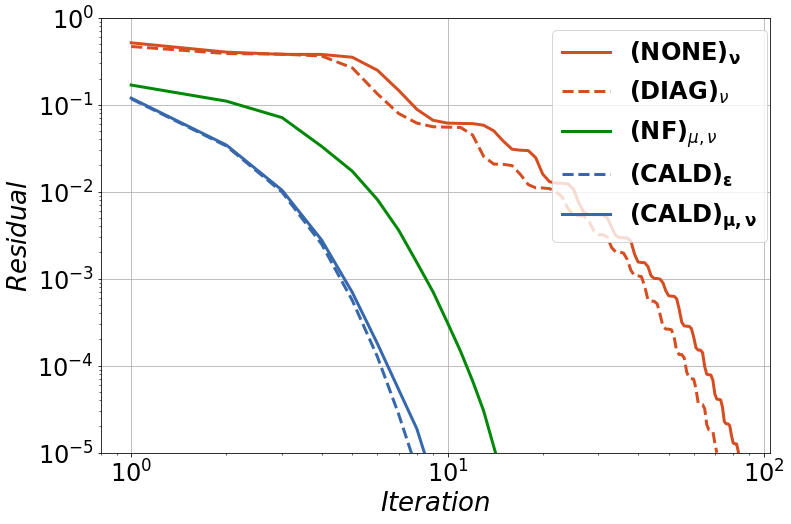

In [82]:
from matplotlib import pyplot as plt

color_green = tuple(np.array([0,136,8])/255.)
color_red = tuple(np.array([213,78,33])/255.)
color_blue = tuple(np.array([54,104,171])/255.)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)


plt.loglog(res_none, label=r'${\bf(NONE)_{\nu}}$', color=color_red, linewidth=3)

plt.loglog(res_diag, label=r'${\bf(DIAG)}_\nu$', color=color_red, linestyle='--', linewidth=3)

plt.loglog(res_nf, label=r'${\bf(NF)}_{\mu,\nu}$', color=color_green, linewidth=3)

plt.loglog(res_eps, label=r'${\bf (CALD)_{\varepsilon}}$', color=color_blue,linestyle='--', linewidth=3)

plt.loglog(res_bi, label=r'${\bf (CALD)_{\mu,\nu}}$', color=color_blue, linewidth=3)

#plt.xticks(np.array([-4,0,4]))
plt.yticks(np.array([1,1e-1,1e-2,1e-3,1e-4,1e-5]))
#plt.yticks(np.array([-4,0,4]))
plt.tick_params(axis='both', labelsize=24)
plt.xlabel(r'$Iteration$',fontsize=26)
plt.ylabel(r'$Residual$',fontsize=26)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.835,1),fontsize=24)
plt.grid(True)
plt.ylim(1e-5,1)
plt.show()

Figure: GMRES Iterations for the parameters mentioned above